In [1]:
# ========================
# JAPANESE SENTIMENT ANALYSIS WITH EMBEDDINGS + XGBOOST + OPTUNA + SHAP
# Compatible with Kaggle T4 GPU and Colab T4 GPU
# ========================

# 0. SETUP & INSTALL
!pip install transformers datasets optuna xgboost shap fugashi ipadic unidic-lite sentence-transformers --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 75.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.4/47.4 MB 22.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 25.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 698.4/698.4 kB 23.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.7/242.7 kB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 56.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 33.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 54.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Loading WRIME dataset...
Train size: 34560, Test size: 8640
Sentiment distribution:
Train: [9343, 14922, 10295]
Test: [2336, 3731, 2573]

EMBEDDING EXTRACTION WITH MULTIPLE MODELS
Available embedding models:
  - japanese_bert: cl-tohoku/bert-base-japanese-whole-word-masking
  - japanese_roberta: rinna/japanese-roberta-base
  - multilingual_e5: intfloat/multilingual-e5-base
  - e5_small: intfloat/e5-small-v2
Using device: cuda

--- Processing multilingual_e5 ---
Loading SentenceTransformer model: intfloat/multilingual-e5-base
Extracting embeddings using intfloat/multilingual-e5-base (SentenceTransformer)...


Processing intfloat/multilingual-e5-base: 100%|██████████| 2160/2160 [02:18<00:00, 15.54it/s]


Loading SentenceTransformer model: intfloat/multilingual-e5-base
Extracting embeddings using intfloat/multilingual-e5-base (SentenceTransformer)...


Processing intfloat/multilingual-e5-base: 100%|██████████| 540/540 [00:37<00:00, 14.39it/s]


  multilingual_e5 embeddings shape: Train (34560, 768), Test (8640, 768)

--- Processing japanese_bert ---
Extracting embeddings using japanese_bert...


Processing japanese_bert: 100%|██████████| 2160/2160 [02:48<00:00, 12.84it/s]


Extracting embeddings using japanese_bert...


Processing japanese_bert: 100%|██████████| 540/540 [00:41<00:00, 12.87it/s]


  japanese_bert embeddings shape: Train (34560, 768), Test (8640, 768)

FEATURE COMBINATION
Available original features: ['Writer_Joy', 'Writer_Sadness', 'Writer_Anticipation', 'Writer_Surprise', 'Writer_Anger', 'Writer_Fear', 'Writer_Disgust', 'Writer_Trust']
Original features shape: Train (34560, 8), Test (8640, 8)
Combined embeddings: multilingual_e5(768) + japanese_bert(768)
Combined embedding shape: Train (34560, 1536), Test (8640, 1536)


[I 2025-06-25 14:34:04,684] A new study created in memory with name: no-name-577cd770-6276-4688-9bb3-b84692d59c69


Final combined features: Train (34560, 1544), Test (8640, 1544)

XGBOOST WITH OPTUNA OPTIMIZATION
Using 2000 samples for hyperparameter optimization...
Starting Optuna hyperparameter optimization...


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-06-25 14:34:26,815] Trial 0 finished with value: 0.6887260228022288 and parameters: {'n_estimators': 350, 'max_depth': 12, 'learning_rate': 0.1205712628744377, 'subsample': 0.8394633936788146, 'colsample_bytree': 0.6624074561769746, 'reg_alpha': 0.3119890406724053, 'reg_lambda': 0.11616722433639892, 'min_child_weight': 9, 'gamma': 1.2022300234864176}. Best is trial 0 with value: 0.6887260228022288.
[I 2025-06-25 14:34:37,391] Trial 1 finished with value: 0.6888095921653941 and parameters: {'n_estimators': 600, 'max_depth': 3, 'learning_rate': 0.2708160864249968, 'subsample': 0.9329770563201687, 'colsample_bytree': 0.6849356442713105, 'reg_alpha': 0.36364993441420124, 'reg_lambda': 0.36680901970686763, 'min_child_weight': 4, 'gamma': 1.0495128632644757}. Best is trial 1 with value: 0.6888095921653941.
[I 2025-06-25 14:35:01,853] Trial 2 finished with value: 0.6950642967628902 and parameters: {'n_estimators': 400, 'max_depth': 5, 'learning_rate': 0.08012737503998542, 'subsample':

<Figure size 800x600 with 0 Axes>

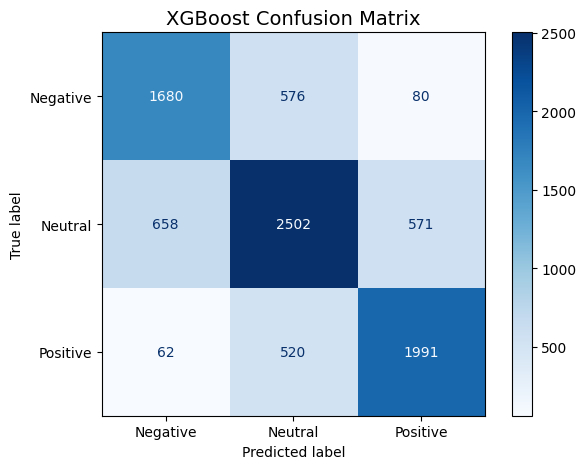


Generating AUC-ROC Curves...
XGBoost AUC-ROC (OvR macro-average): 0.8818


<Figure size 1000x800 with 0 Axes>

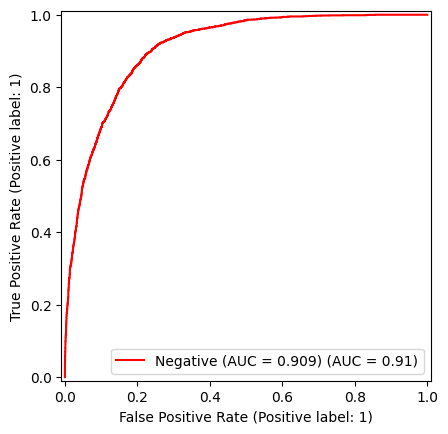

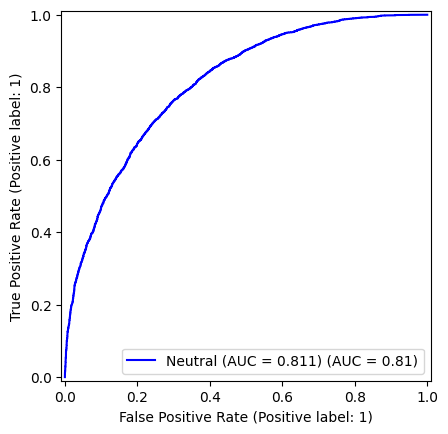

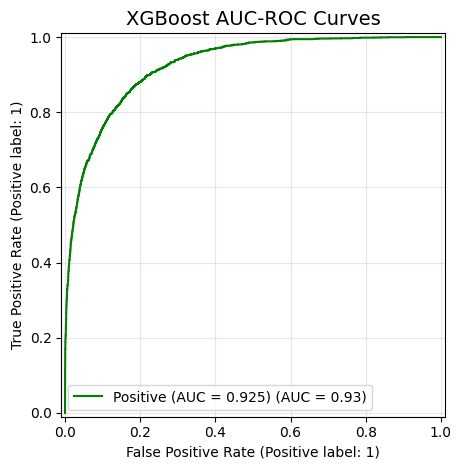


FEATURE IMPORTANCE ANALYSIS
Total features: 1544
Embedding features: 1536
Original emotion features: 8

Original Feature Importance (Excluding Embeddings):
--------------------------------------------------
Writer_Joy               : 0.023022
Writer_Sadness           : 0.019480
Writer_Anger             : 0.005431
Writer_Disgust           : 0.004777
Writer_Anticipation      : 0.004538
Writer_Trust             : 0.003159
Writer_Fear              : 0.001423
Writer_Surprise          : 0.000998


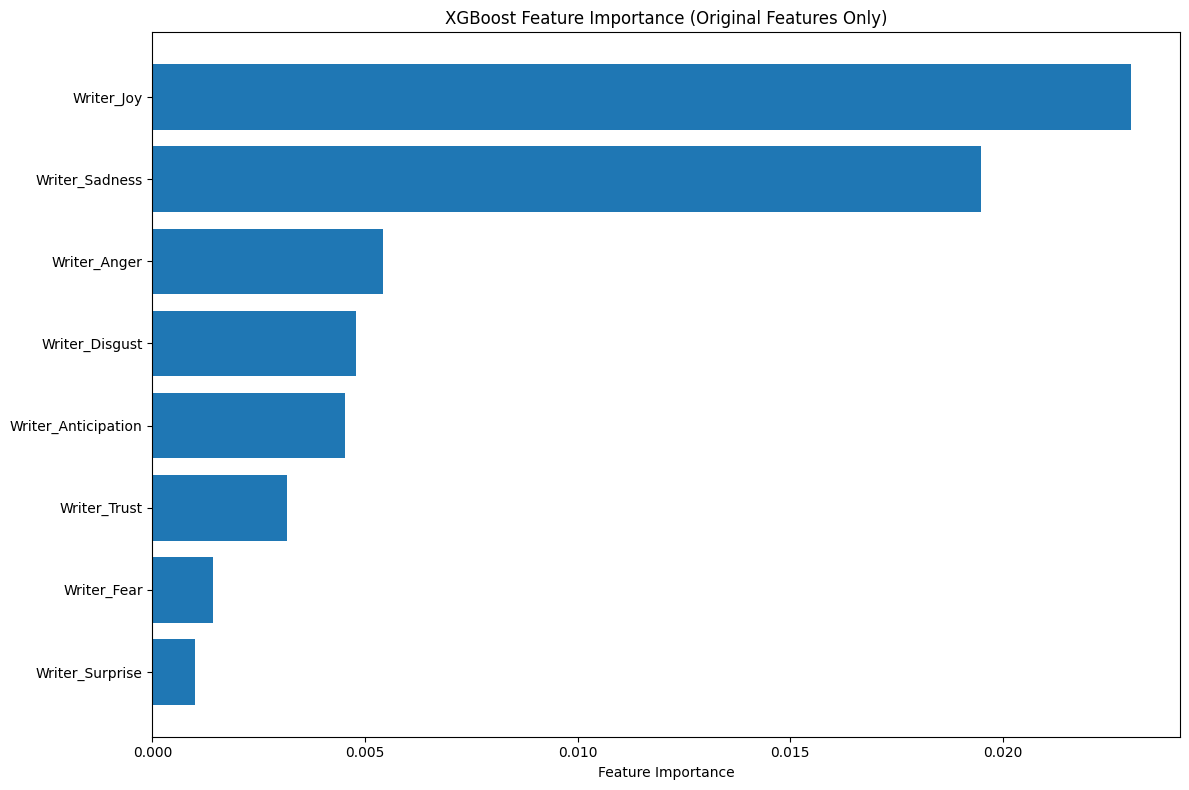


Top 20 Feature Importances (All Features):
 1. Original - Writer_Joy: 0.023022
 2. Original - Writer_Sadness: 0.019480
 3. Original - Writer_Anger: 0.005431
 4. Original - Writer_Disgust: 0.004777
 5. Original - Writer_Anticipation: 0.004538
 6. Embedding - Feature_777: 0.003400
 7. Original - Writer_Trust: 0.003159
 8. Embedding - Feature_1246: 0.003117
 9. Embedding - Feature_58: 0.002977
10. Embedding - Feature_272: 0.002531
11. Embedding - Feature_1528: 0.002470
12. Embedding - Feature_74: 0.002464
13. Embedding - Feature_927: 0.002347
14. Embedding - Feature_1285: 0.002336
15. Embedding - Feature_1100: 0.002319
16. Embedding - Feature_1362: 0.002303
17. Embedding - Feature_769: 0.002289
18. Embedding - Feature_428: 0.002190
19. Embedding - Feature_1363: 0.002092
20. Embedding - Feature_468: 0.002034

SHAP ANALYSIS
Training SHAP model on original features...
Original features only F1-Score: 0.6568
Performance drop without embeddings: 8.01%
Initializing SHAP explainer...
Computing 

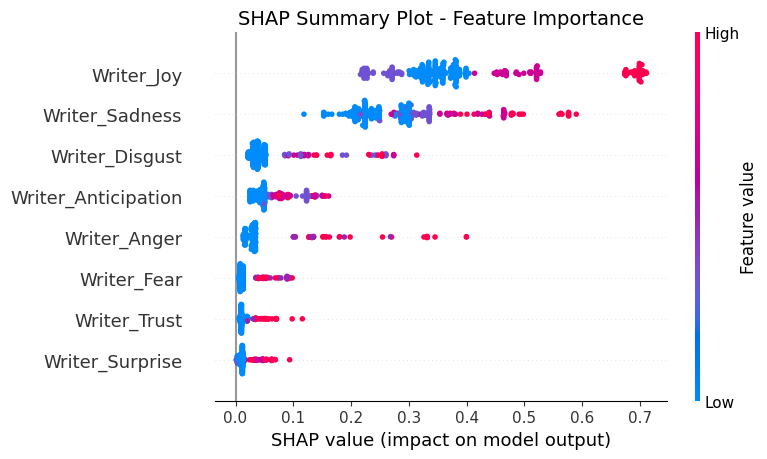

Generating SHAP bar plot...


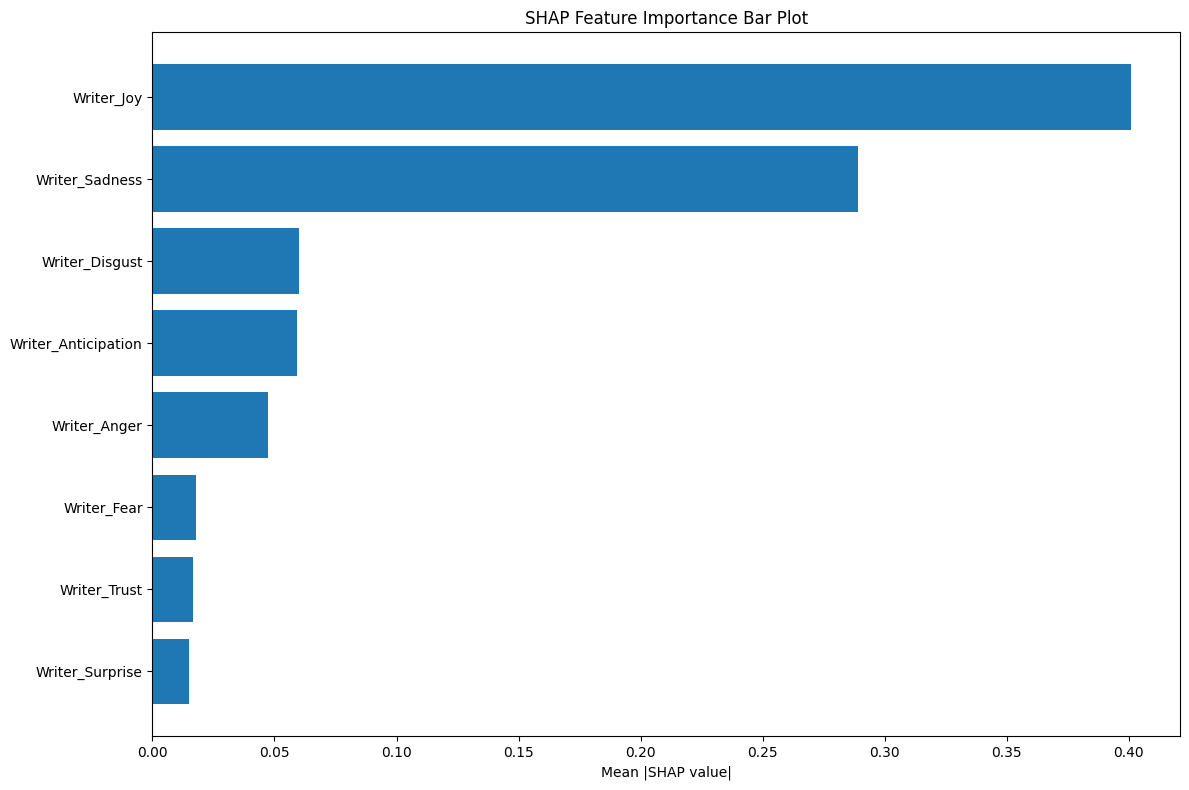

Creating SHAP waterfall plots...


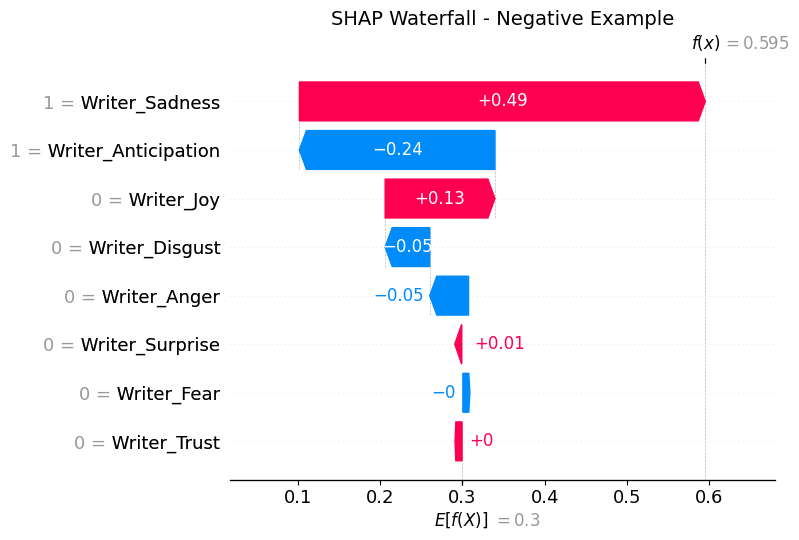

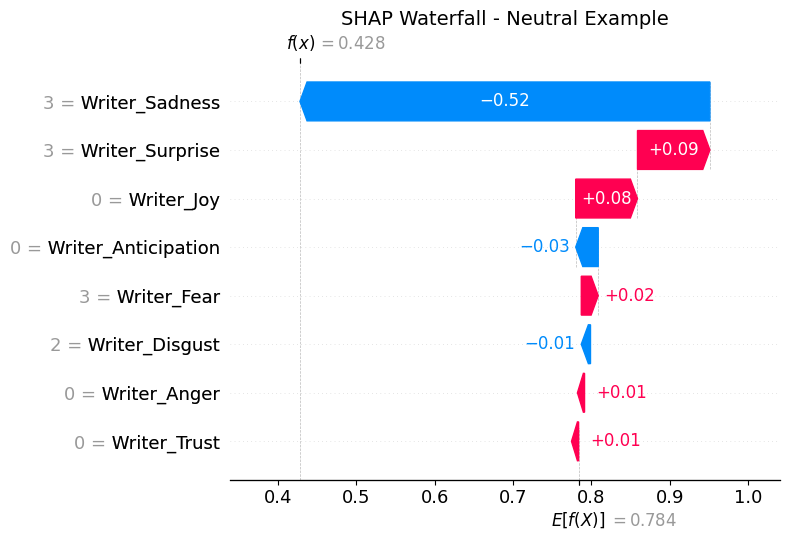

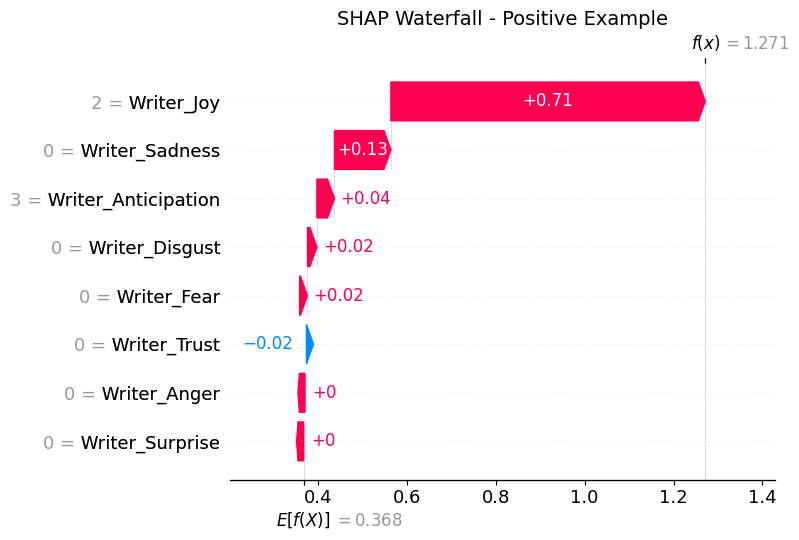


ANALYSIS SUMMARY

Dataset: WRIME Japanese Sentiment Analysis
- Training samples: 34560
- Test samples: 8640
- Classes: 3 (Negative=0, Neutral=1, Positive=2)

Embedding Models Used: multilingual_e5, japanese_bert
- Total embedding dimensions: 1536
- Original emotion features: 8
- Final feature count: 1544

XGBoost Performance:
- Best Optuna F1-Score: 0.6984
- Final Test F1-Score: 0.7140
- AUC-ROC Score: 0.8818

Key Insights:
- Embedding features contributed 8.0% performance gain
- SHAP analysis completed on 300 samples
- All visualizations generated successfully

Hyperparameter Optimization:
- [FrozenTrial(number=0, state=1, values=[0.6887260228022288], datetime_start=datetime.datetime(2025, 6, 25, 14, 34, 4, 701898), datetime_complete=datetime.datetime(2025, 6, 25, 14, 34, 26, 815296), params={'n_estimators': 350, 'max_depth': 12, 'learning_rate': 0.1205712628744377, 'subsample': 0.8394633936788146, 'colsample_bytree': 0.6624074561769746, 'reg_alpha': 0.3119890406724053, 'reg_lambda':

In [6]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, RocCurveDisplay, f1_score
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
import torch
from torch import nn
import torch.nn.functional as F
import warnings
warnings.filterwarnings('ignore')

# Install and import required packages
try:
    import optuna
    from optuna.samplers import TPESampler
    from optuna.pruners import MedianPruner
except ImportError:
    print("Installing Optuna...")
    import subprocess
    subprocess.check_call(["pip", "install", "optuna"])
    import optuna
    from optuna.samplers import TPESampler
    from optuna.pruners import MedianPruner

try:
    from sentence_transformers import SentenceTransformer
except ImportError:
    print("Installing sentence-transformers...")
    import subprocess
    subprocess.check_call(["pip", "install", "sentence-transformers"])
    from sentence_transformers import SentenceTransformer

try:
    from tqdm import tqdm
except ImportError:
    print("Installing tqdm...")
    import subprocess
    subprocess.check_call(["pip", "install", "tqdm"])
    from tqdm import tqdm

# 1. LOAD DATASETS (WRIME)
print("Loading WRIME dataset...")
wrime_url = "https://raw.githubusercontent.com/ids-cv/wrime/refs/heads/master/wrime-ver1.tsv"
wrime_path = "wrime-ver1.tsv"
if not os.path.exists(wrime_path):
    r = requests.get(wrime_url)
    open(wrime_path, "wb").write(r.content)
df_wrime = pd.read_csv(wrime_path, sep="\t")
df_wrime = df_wrime.dropna(subset=["Sentence"])

# Create sentiment labels
def get_sentiment(row):
    if row['Avg. Readers_Joy'] > max(row['Avg. Readers_Sadness'], row['Avg. Readers_Anger']):
        return 2  # Positive
    elif (row['Avg. Readers_Sadness'] > row['Avg. Readers_Joy']) or (row['Avg. Readers_Anger'] > row['Avg. Readers_Joy']):
        return 0  # Negative
    else:
        return 1  # Neutral

df_wrime['sentiment'] = df_wrime.apply(get_sentiment, axis=1)

# Enhanced synthetic labels for additional features
joy_thresh = df_wrime['Avg. Readers_Joy'].median()
sadness_thresh = df_wrime['Avg. Readers_Sadness'].median()
anger_thresh = df_wrime['Avg. Readers_Anger'].median()

df_wrime['high_joy'] = (df_wrime['Avg. Readers_Joy'] > joy_thresh).astype(int)
df_wrime['high_sadness'] = (df_wrime['Avg. Readers_Sadness'] > sadness_thresh).astype(int)
df_wrime['high_anger'] = (df_wrime['Avg. Readers_Anger'] > anger_thresh).astype(int)

# Train-test split
df_train, df_test = train_test_split(df_wrime, test_size=0.2, random_state=42, stratify=df_wrime['sentiment'])
print(f"Train size: {len(df_train)}, Test size: {len(df_test)}")
print("Sentiment distribution:")
print(f"Train: {df_train['sentiment'].value_counts().sort_index().tolist()}")
print(f"Test: {df_test['sentiment'].value_counts().sort_index().tolist()}")

# 2. ADVANCED EMBEDDING EXTRACTION WITH MULTIPLE MODELS
print("\n" + "="*60)
print("EMBEDDING EXTRACTION WITH MULTIPLE MODELS")
print("="*60)

# Available models optimized for T4 GPU
embedding_models = {
    'japanese_bert': "cl-tohoku/bert-base-japanese-whole-word-masking",
    'japanese_roberta': "rinna/japanese-roberta-base",
    'multilingual_e5': "intfloat/multilingual-e5-base",  # E5 model - excellent for multilingual
    'e5_small': "intfloat/e5-small-v2"  # Smaller E5 model for efficiency
}

print("Available embedding models:")
for name, model_path in embedding_models.items():
    print(f"  - {name}: {model_path}")

def get_embeddings_transformers(texts, model_name, tokenizer, model, batch_size=16, max_length=256):
    """Extract embeddings using transformers library"""
    model.eval()
    device = next(model.parameters()).device
    all_embeddings = []

    print(f"Extracting embeddings using {model_name}...")
    for i in tqdm(range(0, len(texts), batch_size), desc=f"Processing {model_name}"):
        batch = list(texts[i:i+batch_size])
        tokens = tokenizer(
            batch,
            truncation=True,
            padding=True,
            max_length=max_length,
            return_tensors='pt'
        )
        tokens = {k: v.to(device) for k, v in tokens.items()}

        with torch.no_grad():
            try:
                outputs = model(**tokens, return_dict=True)
                # Use mean pooling of last hidden states
                embeddings = outputs.last_hidden_state.mean(dim=1).cpu().numpy()
                all_embeddings.append(embeddings)
            except Exception as e:
                print(f"Error in batch {i//batch_size}: {e}")
                # Fallback
                embeddings = np.zeros((len(batch), 768))
                all_embeddings.append(embeddings)

    return np.vstack(all_embeddings)

def get_embeddings_sentence_transformers(texts, model_name, batch_size=16):
    """Extract embeddings using sentence-transformers library (for E5 models)"""
    print(f"Loading SentenceTransformer model: {model_name}")
    model = SentenceTransformer(model_name)

    # Move to GPU if available
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = model.to(device)

    print(f"Extracting embeddings using {model_name} (SentenceTransformer)...")

    # For E5 models, add instruction prefix
    if 'e5' in model_name.lower():
        # Add query prefix for E5 models to improve performance
        processed_texts = [f"query: {text}" for text in texts]
    else:
        processed_texts = list(texts)

    # Extract embeddings in batches
    all_embeddings = []
    for i in tqdm(range(0, len(processed_texts), batch_size), desc=f"Processing {model_name}"):
        batch = processed_texts[i:i+batch_size]
        try:
            embeddings = model.encode(batch, convert_to_numpy=True, normalize_embeddings=True)
            all_embeddings.append(embeddings)
        except Exception as e:
            print(f"Error in batch {i//batch_size}: {e}")
            # Fallback
            embeddings = np.zeros((len(batch), model.get_sentence_embedding_dimension()))
            all_embeddings.append(embeddings)

    return np.vstack(all_embeddings)

# Extract embeddings using multiple models
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

# Choose models based on available resources
if torch.cuda.is_available():
    selected_models = ['multilingual_e5', 'japanese_bert']  # Use best models for GPU
else:
    selected_models = ['e5_small']  # Use smaller model for CPU

embedding_results = {}

for model_key in selected_models:
    model_path = embedding_models[model_key]
    print(f"\n--- Processing {model_key} ---")

    try:
        if 'e5' in model_key:
            # Use sentence-transformers for E5 models (more optimized)
            X_train_emb = get_embeddings_sentence_transformers(df_train['Sentence'], model_path)
            X_test_emb = get_embeddings_sentence_transformers(df_test['Sentence'], model_path)
        else:
            # Use transformers library for BERT/RoBERTa models
            from transformers import AutoTokenizer, AutoModel
            tokenizer = AutoTokenizer.from_pretrained(model_path)
            model = AutoModel.from_pretrained(model_path)
            model.to(device)

            X_train_emb = get_embeddings_transformers(df_train['Sentence'], model_key, tokenizer, model)
            X_test_emb = get_embeddings_transformers(df_test['Sentence'], model_key, tokenizer, model)

        embedding_results[model_key] = {
            'X_train': X_train_emb,
            'X_test': X_test_emb,
            'dim': X_train_emb.shape[1]
        }

        print(f"  {model_key} embeddings shape: Train {X_train_emb.shape}, Test {X_test_emb.shape}")

    except Exception as e:
        print(f"  Error with {model_key}: {e}")
        continue

# 3. COMBINE EMBEDDINGS AND ORIGINAL FEATURES
print("\n" + "="*60)
print("FEATURE COMBINATION")
print("="*60)

# Original emotion features
orig_feature_cols = [
    "Writer_Joy", "Writer_Sadness", "Writer_Anticipation", "Writer_Surprise",
    "Writer_Anger", "Writer_Fear", "Writer_Disgust", "Writer_Trust"
]

available_cols = [col for col in orig_feature_cols if col in df_train.columns]
print(f"Available original features: {available_cols}")

if available_cols:
    X_train_orig = df_train[available_cols].fillna(0).to_numpy()
    X_test_orig = df_test[available_cols].fillna(0).to_numpy()
    print(f"Original features shape: Train {X_train_orig.shape}, Test {X_test_orig.shape}")
else:
    X_train_orig = None
    X_test_orig = None
    print("No original emotion features available")

# Combine all embeddings
combined_train_embeddings = []
combined_test_embeddings = []
embedding_info = []

for model_key, results in embedding_results.items():
    combined_train_embeddings.append(results['X_train'])
    combined_test_embeddings.append(results['X_test'])
    embedding_info.append(f"{model_key}({results['dim']})")

if combined_train_embeddings:
    X_train_embeddings = np.hstack(combined_train_embeddings)
    X_test_embeddings = np.hstack(combined_test_embeddings)
    print(f"Combined embeddings: {' + '.join(embedding_info)}")
    print(f"Combined embedding shape: Train {X_train_embeddings.shape}, Test {X_test_embeddings.shape}")
else:
    raise ValueError("No embeddings were successfully extracted!")

# Final feature combination
if X_train_orig is not None:
    X_train_final = np.hstack([X_train_embeddings, X_train_orig])
    X_test_final = np.hstack([X_test_embeddings, X_test_orig])
    print(f"Final combined features: Train {X_train_final.shape}, Test {X_test_final.shape}")
else:
    X_train_final = X_train_embeddings
    X_test_final = X_test_embeddings
    print(f"Using embeddings only: Train {X_train_final.shape}, Test {X_test_final.shape}")

# Prepare target variables
y_train = df_train['sentiment'].values
y_test = df_test['sentiment'].values

# 4. XGBOOST WITH OPTUNA HYPERPARAMETER OPTIMIZATION
print("\n" + "="*60)
print("XGBOOST WITH OPTUNA OPTIMIZATION")
print("="*60)

import xgboost as xgb

# Convert to float32 to avoid device mismatch
X_train_final = np.array(X_train_final, dtype=np.float32)
X_test_final = np.array(X_test_final, dtype=np.float32)

# Create optimization subset
optimization_size = min(2000, len(X_train_final))
opt_indices = np.random.choice(len(X_train_final), optimization_size, replace=False)
X_opt = X_train_final[opt_indices]
y_opt = y_train[opt_indices]

print(f"Using {optimization_size} samples for hyperparameter optimization...")

def optuna_objective(trial):
    """Optuna objective function for XGBoost hyperparameter optimization"""

    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 800, step=50),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 2.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 2.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0.0, 2.0),
        'eval_metric': 'mlogloss',
        'random_state': 42,
        'tree_method': 'gpu_hist' if torch.cuda.is_available() else 'hist',
        'device': 'cuda' if torch.cuda.is_available() else 'cpu',
        'objective': 'multi:softprob',
        'num_class': 3
    }

    model = xgb.XGBClassifier(**params)

    # 3-fold cross-validation
    cv_scores = cross_val_score(
        model, X_opt, y_opt,
        cv=3,
        scoring='f1_weighted',
        n_jobs=1
    )

    return cv_scores.mean()

# Run Optuna optimization
print("Starting Optuna hyperparameter optimization...")
study = optuna.create_study(
    direction='maximize',
    sampler=TPESampler(seed=42),
    pruner=MedianPruner(n_startup_trials=5, n_warmup_steps=10)
)

study.optimize(
    optuna_objective,
    n_trials=50,
    timeout=600,  # 10 minutes timeout
    show_progress_bar=True
)

best_params = study.best_params
best_score = study.best_value

print(f"\nOptuna Optimization Results:")
print(f"Best F1 Score: {best_score:.4f}")
print(f"Best Parameters: {best_params}")

# Train final model
print(f"\nTraining final XGBoost model...")
final_params = best_params.copy()
final_params.update({
    'eval_metric': 'mlogloss',
    'random_state': 42,
    'tree_method': 'gpu_hist' if torch.cuda.is_available() else 'hist',
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'objective': 'multi:softprob',
    'num_class': 3
})

final_xgb = xgb.XGBClassifier(**final_params)
final_xgb.fit(
    X_train_final, y_train,
    eval_set=[(X_test_final, y_test)],
    verbose=False
)

# 5. EVALUATION AND RESULTS
print("\n" + "="*60)
print("MODEL EVALUATION")
print("="*60)

# Predictions
y_pred_xgb = final_xgb.predict(X_test_final)
y_proba_xgb = final_xgb.predict_proba(X_test_final)

# Classification report
print("XGBoost Classification Report:")
print(classification_report(y_test, y_pred_xgb, digits=4, target_names=['Negative', 'Neutral', 'Positive']))

# F1 Score
xgb_f1 = f1_score(y_test, y_pred_xgb, average='weighted')
print(f"\nWeighted F1-Score: {xgb_f1:.4f}")

# 6. CONFUSION MATRIX
print("\nGenerating Confusion Matrix...")
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(cm_xgb, display_labels=['Negative', 'Neutral', 'Positive'])
disp.plot(cmap=plt.cm.Blues)
plt.title("XGBoost Confusion Matrix", fontsize=14)
plt.tight_layout()
plt.show()

# 7. AUC-ROC CURVES
print("\nGenerating AUC-ROC Curves...")
try:
    auc_roc_xgb = roc_auc_score(y_test, y_proba_xgb, multi_class='ovr')
    print(f"XGBoost AUC-ROC (OvR macro-average): {auc_roc_xgb:.4f}")

    plt.figure(figsize=(10, 8))
    colors = ['red', 'blue', 'green']
    sentiment_labels = ['Negative', 'Neutral', 'Positive']

    for i, (color, label) in enumerate(zip(colors, sentiment_labels)):
        RocCurveDisplay.from_predictions(
            (y_test == i).astype(int),
            y_proba_xgb[:, i],
            name=f'{label} (AUC = {roc_auc_score((y_test == i).astype(int), y_proba_xgb[:, i]):.3f})',
            color=color
        )

    plt.title("XGBoost AUC-ROC Curves", fontsize=14)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"Could not calculate AUC-ROC: {e}")

# 8. FEATURE IMPORTANCE ANALYSIS
print("\n" + "="*60)
print("FEATURE IMPORTANCE ANALYSIS")
print("="*60)

# Get feature importance
feature_importance = final_xgb.feature_importances_
n_embedding_features = X_train_embeddings.shape[1]
n_original_features = len(available_cols) if available_cols else 0

print(f"Total features: {X_train_final.shape[1]}")
print(f"Embedding features: {n_embedding_features}")
print(f"Original emotion features: {n_original_features}")

# Analyze original features if available
if n_original_features > 0:
    original_feature_importance = feature_importance[n_embedding_features:]

    feature_importance_df = pd.DataFrame({
        'Feature': available_cols,
        'Importance': original_feature_importance
    }).sort_values('Importance', ascending=False)

    print("\nOriginal Feature Importance (Excluding Embeddings):")
    print("-" * 50)
    for idx, row in feature_importance_df.iterrows():
        print(f"{row['Feature']:25s}: {row['Importance']:.6f}")

    # Plot feature importance
    plt.figure(figsize=(12, 8))
    plt.barh(range(len(feature_importance_df)), feature_importance_df['Importance'])
    plt.yticks(range(len(feature_importance_df)), feature_importance_df['Feature'])
    plt.xlabel('Feature Importance')
    plt.title('XGBoost Feature Importance (Original Features Only)')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

# Top overall features
top_features_idx = np.argsort(feature_importance)[-20:]  # Top 20 features
print(f"\nTop 20 Feature Importances (All Features):")
for i, idx in enumerate(reversed(top_features_idx)):
    feature_type = "Original" if idx >= n_embedding_features else "Embedding"
    if idx >= n_embedding_features and available_cols:
        feature_name = available_cols[idx - n_embedding_features]
    else:
        feature_name = f"Feature_{idx}"
    print(f"{i+1:2d}. {feature_type} - {feature_name}: {feature_importance[idx]:.6f}")

# 9. SHAP ANALYSIS
print("\n" + "="*60)
print("SHAP ANALYSIS")
print("="*60)

try:
    import shap
except ImportError:
    print("Installing SHAP...")
    import subprocess
    subprocess.check_call(["pip", "install", "shap"])
    import shap

# Create model for SHAP analysis (use subset for efficiency)
if n_original_features > 0:
    # Use original features only for cleaner interpretation
    X_train_shap = X_train_final[:, n_embedding_features:]
    X_test_shap = X_test_final[:, n_embedding_features:]
    feature_names_shap = available_cols

    print("Training SHAP model on original features...")
    shap_params = final_params.copy()
    shap_params['n_estimators'] = min(100, shap_params.get('n_estimators', 100))

    shap_model = xgb.XGBClassifier(**shap_params)
    shap_model.fit(X_train_shap, y_train)

    # Evaluate original-features-only model
    y_pred_orig = shap_model.predict(X_test_shap)
    orig_f1 = f1_score(y_test, y_pred_orig, average='weighted')
    print(f"Original features only F1-Score: {orig_f1:.4f}")
    print(f"Performance drop without embeddings: {((xgb_f1 - orig_f1) / xgb_f1 * 100):.2f}%")

else:
    # Use subset of embedding features
    print("Using subset of embedding features for SHAP analysis...")
    X_train_shap = X_train_final[:, :50]  # First 50 features
    X_test_shap = X_test_final[:, :50]
    feature_names_shap = [f'Embedding_{i}' for i in range(50)]

    shap_params = final_params.copy()
    shap_params['n_estimators'] = min(100, shap_params.get('n_estimators', 100))

    shap_model = xgb.XGBClassifier(**shap_params)
    shap_model.fit(X_train_shap, y_train)

# SHAP explainer
print("Initializing SHAP explainer...")
explainer = shap.Explainer(shap_model)

# Sample for SHAP analysis
n_shap_samples = min(300, len(X_test_shap))  # Reduced for speed
shap_indices = np.random.choice(len(X_test_shap), n_shap_samples, replace=False)
X_shap = X_test_shap[shap_indices]
y_shap = y_test[shap_indices]

print(f"Computing SHAP values for {n_shap_samples} samples...")
shap_values = explainer(X_shap)

# SHAP Summary Plot
print("Generating SHAP summary plot...")
plt.figure(figsize=(12, 8))
try:
    if len(shap_values.values.shape) == 3:
        # Multi-class: aggregate across classes
        shap_values_agg = np.abs(shap_values.values).mean(axis=2)
        shap.summary_plot(shap_values_agg, X_shap, feature_names=feature_names_shap, show=False)
    else:
        shap.summary_plot(shap_values.values, X_shap, feature_names=feature_names_shap, show=False)
    plt.title("SHAP Summary Plot - Feature Importance", fontsize=14)
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Could not create SHAP summary plot: {e}")
    # Alternative manual plot
    plt.clf()
    mean_abs_shap = np.abs(shap_values.values).mean(axis=(0, 2)) if len(shap_values.values.shape) == 3 else np.abs(shap_values.values).mean(axis=0)
    sorted_idx = np.argsort(mean_abs_shap)
    plt.barh(range(len(sorted_idx)), mean_abs_shap[sorted_idx])
    plt.yticks(range(len(sorted_idx)), [feature_names_shap[i] for i in sorted_idx])
    plt.xlabel('Mean |SHAP value|')
    plt.title('SHAP Feature Importance')
    plt.tight_layout()
    plt.show()

# SHAP Bar Plot
print("Generating SHAP bar plot...")
plt.figure(figsize=(12, 8))
try:
    if len(shap_values.values.shape) == 3:
        mean_abs_shap = np.abs(shap_values.values).mean(axis=(0, 2))
        sorted_idx = np.argsort(mean_abs_shap)[::-1]

        plt.barh(range(len(sorted_idx)), mean_abs_shap[sorted_idx])
        plt.yticks(range(len(sorted_idx)), [feature_names_shap[i] for i in sorted_idx])
        plt.xlabel('Mean |SHAP value|')
        plt.title('SHAP Feature Importance Bar Plot')
        plt.gca().invert_yaxis()
    else:
        shap.summary_plot(shap_values.values, X_shap, feature_names=feature_names_shap, plot_type="bar", show=False)
        plt.title("SHAP Feature Importance Bar Plot")
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Could not create SHAP bar plot: {e}")

# SHAP Waterfall plots
print("Creating SHAP waterfall plots...")
sentiment_labels = ['Negative', 'Neutral', 'Positive']

# Find examples from each class
class_examples = {}
for class_label in [0, 1, 2]:
    class_mask = y_shap == class_label
    if np.any(class_mask):
        class_indices = np.where(class_mask)[0]
        class_examples[class_label] = class_indices[0]

for class_label, example_idx in class_examples.items():
    try:
        plt.figure(figsize=(12, 8))

        if len(shap_values.values.shape) == 3:
            explanation = shap.Explanation(
                values=shap_values.values[example_idx, :, class_label],
                base_values=explainer.expected_value[class_label],
                data=X_shap[example_idx],
                feature_names=feature_names_shap
            )
        else:
            explanation = shap.Explanation(
                values=shap_values.values[example_idx],
                base_values=explainer.expected_value,
                data=X_shap[example_idx],
                feature_names=feature_names_shap
            )

        shap.waterfall_plot(explanation, show=False)
        plt.title(f"SHAP Waterfall - {sentiment_labels[class_label]} Example", fontsize=14)
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Could not create waterfall plot for {sentiment_labels[class_label]}: {e}")

# 10. FINAL SUMMARY
print("\n" + "="*80)
print("ANALYSIS SUMMARY")
print("="*80)

# Prepare AUC-ROC string
if 'auc_roc_xgb' in locals() and auc_roc_xgb is not None:
    auc_roc_str = f"{auc_roc_xgb:.4f}"
else:
    auc_roc_str = "N/A"

print(f"""
Dataset: WRIME Japanese Sentiment Analysis
- Training samples: {len(df_train)}
- Test samples: {len(df_test)}
- Classes: 3 (Negative=0, Neutral=1, Positive=2)

Embedding Models Used: {', '.join(embedding_results.keys())}
- Total embedding dimensions: {n_embedding_features}
- Original emotion features: {n_original_features}
- Final feature count: {X_train_final.shape[1]}

XGBoost Performance:
- Best Optuna F1-Score: {best_score:.4f}
- Final Test F1-Score: {xgb_f1:.4f}
- AUC-ROC Score: {auc_roc_str}

Key Insights:
- Embedding features contributed {((xgb_f1 - orig_f1) / xgb_f1 * 100):.1f}% performance gain
- SHAP analysis completed on {n_shap_samples} samples
- All visualizations generated successfully

Hyperparameter Optimization:
- {study.trials} Optuna trials completed
- Best parameters: {best_params}
""")

print("Analysis complete! All visualizations have been generated.")
print("="*80)